<a href="https://colab.research.google.com/github/AdriaDelhom/CGM/blob/main/GoodResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from data_processing.cgm_data import CGMData, DATA_PATH

## Loading in some data

In [2]:
food = pd.read_csv(f'./{DATA_PATH}/001/Food_Log_001.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)

In [3]:
glu = pd.read_csv(f'./{DATA_PATH}/001/Dexcom_001.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

In [4]:
food5 = pd.read_csv(f'./{DATA_PATH}/005/Food_Log_005.csv', index_col=['time_begin'], parse_dates=['time_begin'], skipinitialspace=True)
glu5 = pd.read_csv(f'./{DATA_PATH}/005/Dexcom_005.csv', header=0, skiprows=range(1, 13), index_col=['Timestamp (YYYY-MM-DDThh:mm:ss)'], parse_dates=['Timestamp (YYYY-MM-DDThh:mm:ss)'])

### Data Notes
- Patient 003 food log has no headers

In [5]:
# Plot the series with food consumption marked
def plot_series_with_food(series, food, time_start, time_end):
  series_slice = series.loc[time_start:time_end, 'Glucose Value (mg/dL)']
  series_slice_range = series_slice.max() - series_slice.min()
  series_slice_mid = (series_slice.max() + series_slice.min()) / 2
  food_slice = food[(time_start <= food.index) & (food.index <= pd.Timestamp(time_end) + pd.Timedelta(days=1))]

  ymin = series_slice_mid - series_slice_range * 0.6
  ymax = series_slice_mid + series_slice_range * 0.6

  plt.figure(figsize=(20, 4))
  plt.plot(series_slice)
  plt.vlines(food_slice.index, ymin=ymin, ymax=ymax, colors='red')

## Exmaple Glucose vs Food Consumption
The last day charts show the period with no food consumption followed by Boost

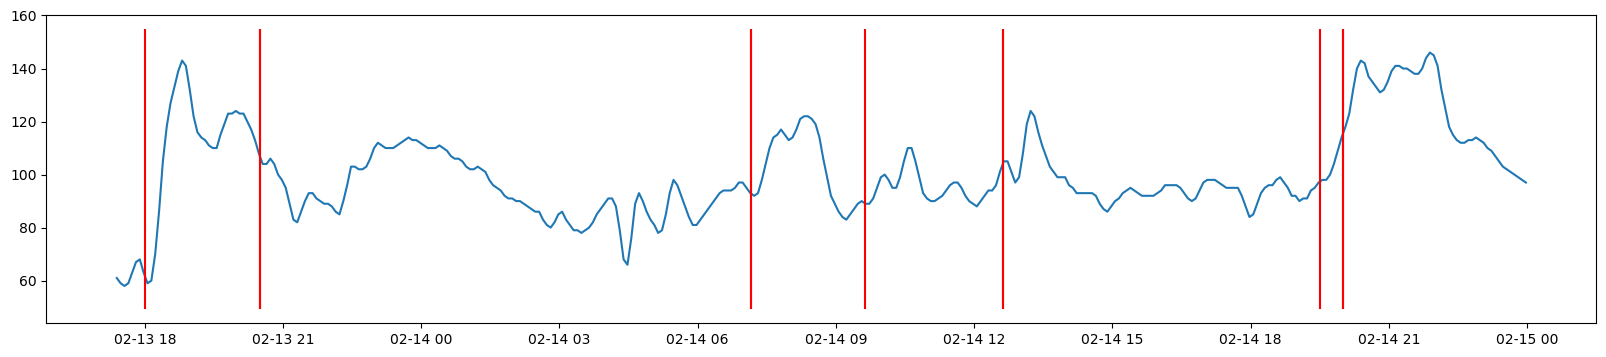

In [6]:
plot_series_with_food(glu, food, '2020-02-13', '2020-02-14')

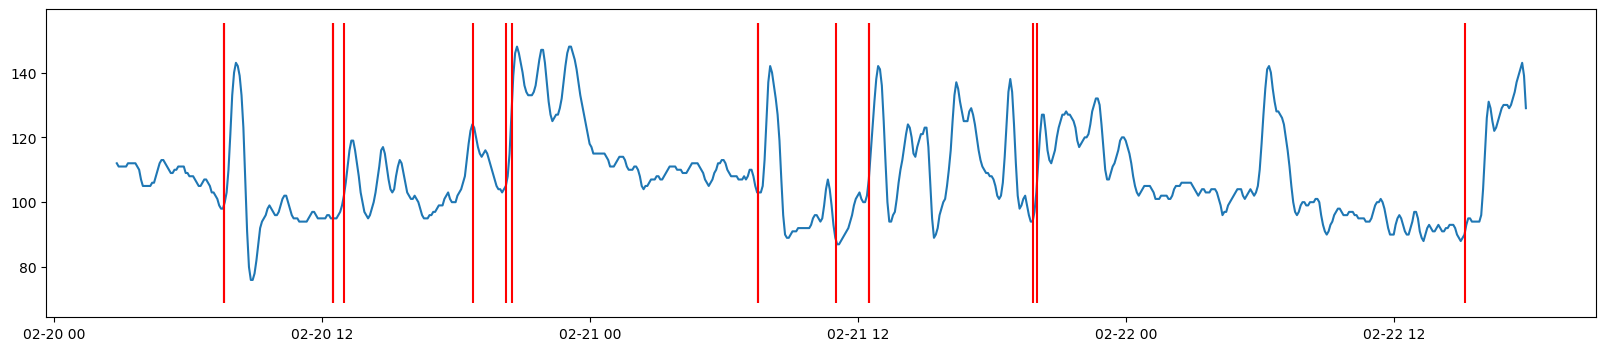

In [7]:
plot_series_with_food(glu, food, '2020-02-20', '2020-02-22')

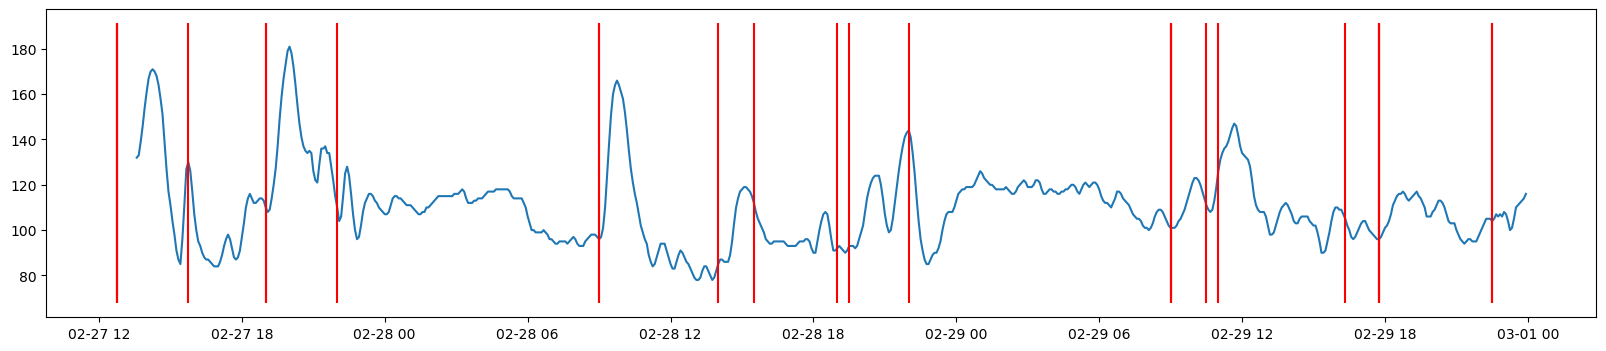

In [8]:
plot_series_with_food(glu5, food5, '2020-02-27', '2020-02-29')

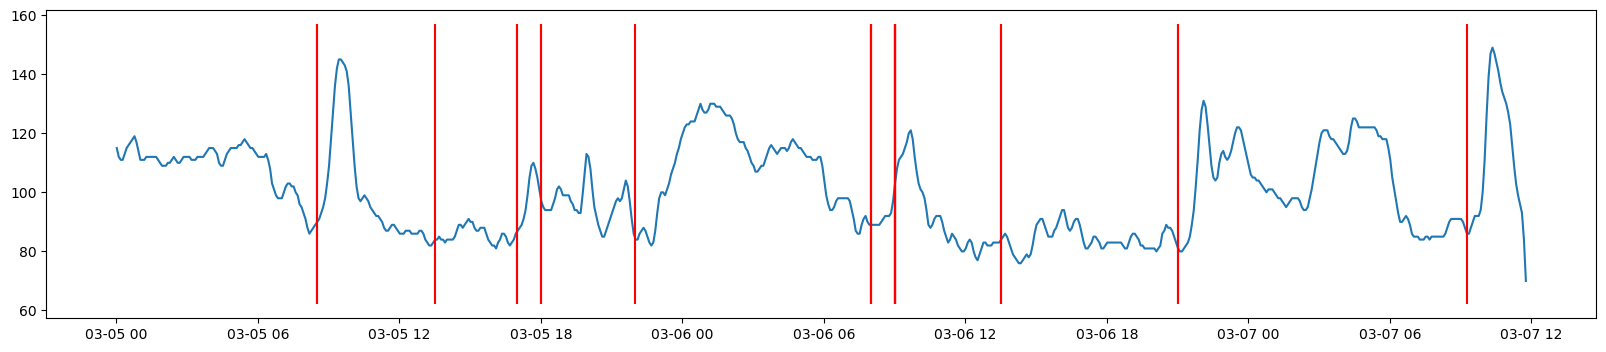

In [9]:
plot_series_with_food(glu5, food5, '2020-03-05', '2020-03-07')

In [10]:
data = CGMData()
print(data[1].gender)
print(data[1].hba1c)
# print(data[1].glu.head(5))

FEMALE
5.5


In [11]:
data[6].food['searched_food']

time_begin
2020-02-28 08:10:00     
2020-02-28 09:15:00     
2020-02-28 11:25:00     
2020-02-28 15:30:00     
2020-02-28 19:30:00     
                      ..
2020-03-08 12:30:00     
2020-03-08 12:30:00     
2020-03-08 19:50:00     
2020-03-08 19:50:00     
2020-03-09 07:30:00     
Name: searched_food, Length: 73, dtype: object

In [12]:
# Verifying all datasets load properly
for i in range(2, 3):
  for data_str in ['acc', 'bvp', 'glu', 'eda', 'food', 'hr', 'ibi', 'temp']:
    print(i, data_str)
    try:
      print(data[i].__getattribute__(data_str).head(5))
    except Exception as e:
      print(f"Error on patient {i} with {data_str}: {e}")

2 acc
                               acc_x     acc_y     acc_z
datetime                                                
2020-02-21 09:19:06.000000 -1.544882 -5.407087  8.033386
2020-02-21 09:19:06.031250 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.062500 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.093750 -1.544882 -5.407087  7.878898
2020-02-21 09:19:06.125000 -1.544882 -5.407087  7.878898
2 bvp
                            bvp
datetime                       
2020-02-21 09:19:06.000000 -0.0
2020-02-21 09:19:06.015625 -0.0
2020-02-21 09:19:06.031250 -0.0
2020-02-21 09:19:06.046875 -0.0
2020-02-21 09:19:06.062500 -0.0
2 glu
                     glucose
datetime                    
2020-02-21 11:08:36    186.0
2020-02-21 11:13:36    181.0
2020-02-21 11:18:36    175.0
2020-02-21 11:23:35    168.0
2020-02-21 11:28:36    163.0
2 eda
                              eda
datetime                         
2020-02-21 09:19:06.000  0.000000
2020-02-21 09:19:06.250  0.139648
2020-02-21 09:

## Look at post meal glucose response ofr single patient

In [13]:
# Get the curve immediately after food consumption
def get_meal_spike(glu, time, duration):
  # get a slice of glu for duration hours after time
  glu_slice = glu.loc[time:time + pd.Timedelta(hours=duration), 'glucose']
  glu_slice.index = glu_slice.index - glu_slice.index[0]
  # sometimes the measurements are off by a second
  glu_slice.index = glu_slice.index.round(freq='5min')
  return glu_slice

In [14]:
slices = []
for start in food.index:
  slices.append(get_meal_spike(data[1].glu, start, 3))

In [15]:
# TODO Only include spike with a single food item and not consumed iwthin 3 hours of other food items

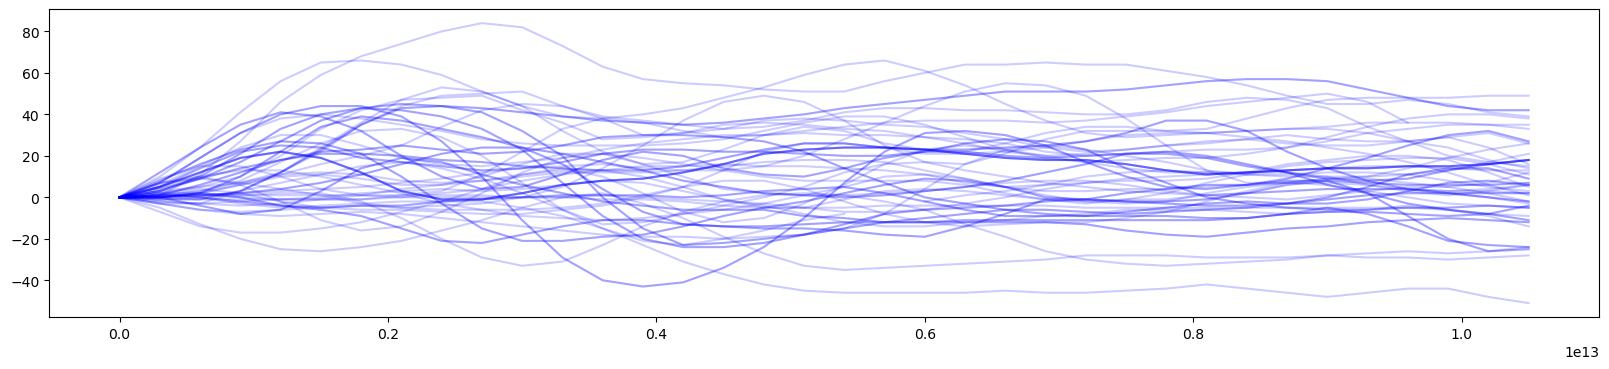

In [16]:
# Meals from patient 1, start aligned
df = pd.concat(slices, axis=1)
df.columns = list(range(df.shape[1]))

plt.figure(figsize=(20, 4))
for col in range(df.shape[1]):
  plt.plot(df[col] - df.iloc[0, col], color='blue', alpha=0.2)

In [17]:
def find_standard_meal(df):
  bfast_filter = df['searched_food'].str.contains('Partly Skimmed Milk') | df['searched_food'].str.contains('Frosted Flakes')
  return df[bfast_filter]

In [18]:
find_standard_meal(data[3].food)

,logged_food,amount,unit,searched_food,calorie,total_carb,sugar,protein,time_end
time_begin,,,,,,,,,
2020-02-23 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-23 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-25 06:50:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-25 06:50:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-27 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-27 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-29 08:15:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-29 08:15:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT


In [19]:
data[3].food[data[3].food['searched_food'].str.contains('Partly Skimmed Milk') | data[3].food['searched_food'].str.contains('Frosted Flakes')]

,logged_food,amount,unit,searched_food,calorie,total_carb,sugar,protein,time_end
time_begin,,,,,,,,,
2020-02-23 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-23 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-25 06:50:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-25 06:50:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-27 05:30:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-27 05:30:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT
2020-02-29 08:15:00,Milk,4.0,ounce,(Natrel) Lactose Free 2% Partly Skimmed Milk,60.0,4.5,4.0,6.0,NaT
2020-02-29 08:15:00,Cornflakes,1.5,cup,(Kellogg's) Frosted Flakes,220.0,52.0,20.0,2.0,NaT


In [20]:
data[2].food.head()

,time_end,logged_food,amount,unit,searched_food,calorie,total_carb,dietary_fiber,sugar,protein,total_fat
time_begin,,,,,,,,,,,
2020-02-21 10:09:00,NaT,Mello Yello,12.0,fluid ounce,Mello Yello,180.0,48.0,0.0,48.0,0.0,0.0
2020-02-21 10:11:00,NaT,(Jimmy Dean) Chicken Biscuit,1.0,NaN,"(Jimmy Dean) Sandwiches, Biscuit Southern Styl...",280.0,32.0,2.0,3.0,13.0,12.0
2020-02-21 12:09:00,NaT,Beef Jerky,2.0,NaN,Large Beef Jerky,164.0,4.4,0.7,3.6,13.0,10.0
2020-02-21 12:12:00,NaT,(Gatorade) Fierce Grape,12.0,fluid ounce,Gatorade Fierce Grape,84.0,21.6,NaN,20.4,0.0,NaN
2020-02-21 14:02:00,NaT,Banquet Chicken Pot Pie,198.0,gram,Banquet Chicken Pot Pie,700.0,66.0,NaN,4.0,24.0,NaN


In [21]:
# Collect standard breakfasts
std_curves = []
for i in range(1, 14):
  std_meal = find_standard_meal(data[i].food)
  if std_meal.empty:
    continue

  meal_times = std_meal.index.unique()
  for time in meal_times:
    std_curves.append(get_meal_spike(data[i].glu, time, 3))
std_curves = pd.concat(std_curves, axis=1)
std_curves.columns = list(range(std_curves.shape[1]))

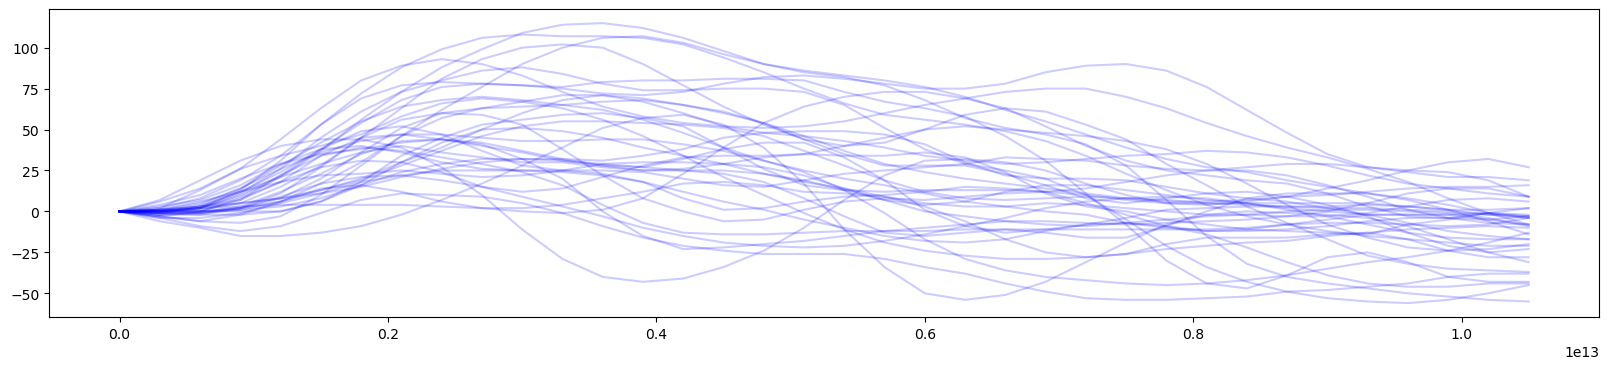

In [22]:
# Standard breakfast responses, start aligned
plt.figure(figsize=(20, 4))
for col in range(std_curves.shape[1]):
  plt.plot(std_curves[col] - std_curves.iloc[0, col], color='blue', alpha=0.2)

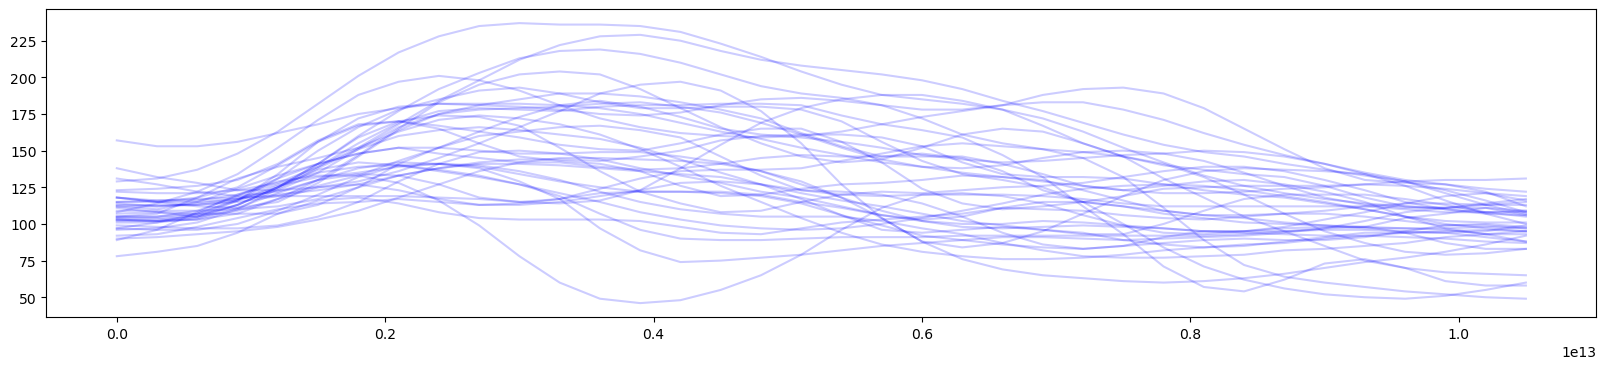

In [23]:
# Standard breakfast responses
plt.figure(figsize=(20, 4))
for col in range(std_curves.shape[1]):
  plt.plot(std_curves[col], color='blue', alpha=0.2)

## Possible compression lows in patient 1 when the the redd acc line is higher
According to the empatica E4 documentation the z-axis (**red** line), is upwards from the "watch face". If the patient is lying on their back, then we would expect a strong negative z-axis signal if their wrist is flat or a strong x-axis (likely **orange**) signal if their wrist is rotated. y-axis (likely **green**) signal should be minimal.
If the patient is lying on their stomach, the we should expect a strong, positive z-axis signal,

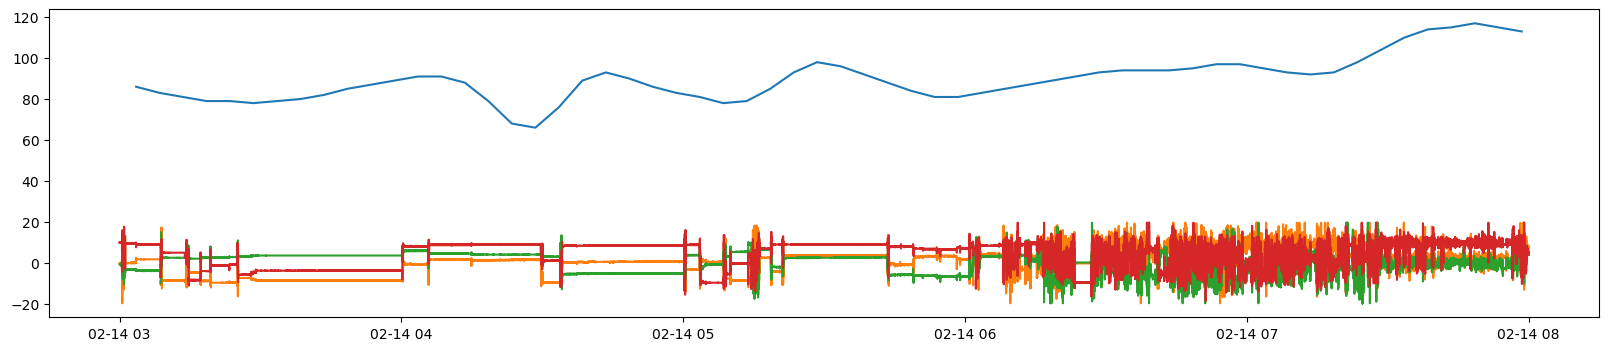

In [24]:
plt.figure(figsize=(20, 4))
plt.plot(data[1].glu[(data[1].glu.index < '2020-02-14 08:00:00') & (data[1].glu.index > '2020-02-14 03:00:00')])
plt.plot(data[1].acc[(data[1].acc.index < '2020-02-14 08:00:00') & (data[1].acc.index > '2020-02-14 03:00:00')])

In [25]:
# Here x and z are negative, potentially indicating the right wrist is rotated slightly counterclockwise, while the patient lying on their back
data[1].acc[(data[1].acc.index < '2020-02-14 03:55:00') & (data[1].acc.index > '2020-02-14 03:54:00')].head()

,acc_x,acc_y,acc_z
datetime,,,
2020-02-14 03:54:00.031250,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.062500,-8.651339,3.553228,-3.862205
2020-02-14 03:54:00.093750,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.125000,-8.496850,3.553228,-3.862205
2020-02-14 03:54:00.156250,-8.651339,3.553228,-3.862205


In [26]:
# z is positive, potentially showing the patient lying on their stomach
# Not sure what is causing y to be negative, arm is likely at an odd angle, wrist parallel to ground
data[1].acc[(data[1].acc.index < '2020-02-14 04:40:00') & (data[1].acc.index > '2020-02-14 04:39:00')].head()

,acc_x,acc_y,acc_z
datetime,,,
2020-02-14 04:39:00.031250,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.062500,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.093750,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.125000,0.308976,-5.252598,8.342362
2020-02-14 04:39:00.156250,0.308976,-5.252598,8.342362


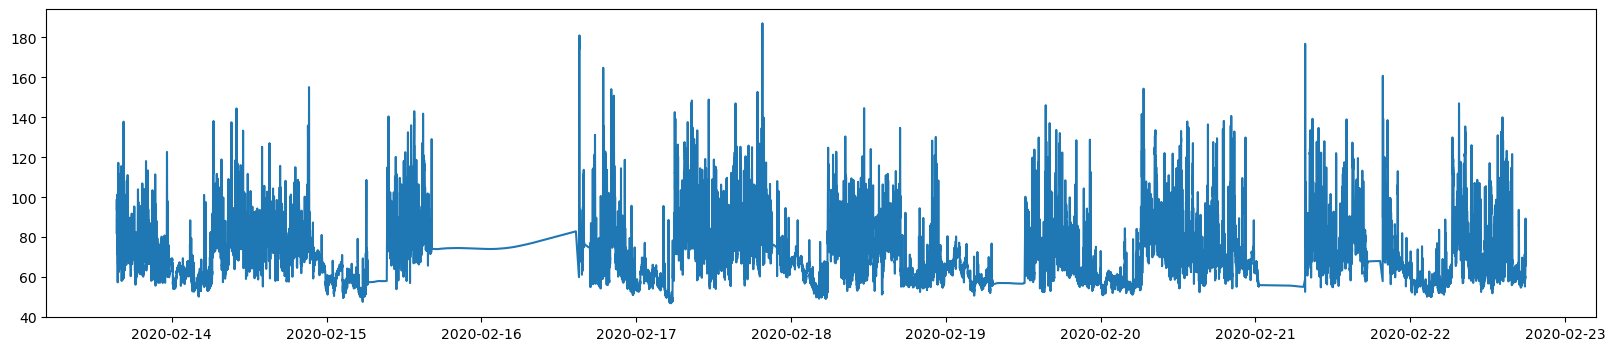

In [27]:
plt.figure(figsize=(20, 4))
plt.plot(data[1].hr)

## Glucose curve processing

In [28]:
# In order of importance
# TODO : Peak value
# TODO: Time to peak
# TODO: Time to start of rise
# TODO: Width of peak (hard to define, make time until body returns to blood sugar before meal)

## Simple time series fit to glu curve on patient 1

In [29]:
# Baseline mean model
data[1].glu.mean()

glucose    106.093713
dtype: float64

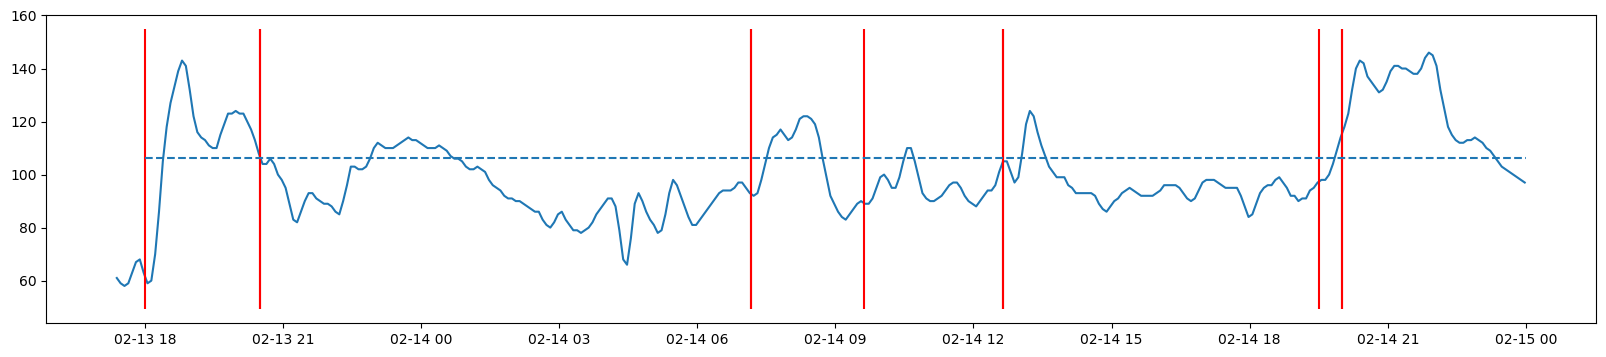

In [30]:
plot_series_with_food(glu, food, '2020-02-13', '2020-02-14')
plt.hlines(data[1].glu.mean(), pd.to_datetime('2020-02-13 18:00:00'), pd.to_datetime('2020-02-15'), linestyles='dashed')

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa as sm

data[1].glu

,glucose
datetime,
2020-02-13 17:23:32,61.0
2020-02-13 17:28:32,59.0
2020-02-13 17:33:32,58.0
2020-02-13 17:38:32,59.0
2020-02-13 17:43:31,63.0
...,...
2020-02-22 17:33:23,139.0
2020-02-22 17:38:23,141.0
2020-02-22 17:43:23,143.0


In [32]:
glu_train = data[1].glu.loc['2020-02-13 00:00:00':'2020-02-18 00:00:00']
glu_test = data[1].glu.loc['2020-02-18 00:00:00':'2020-02-22 18:00:00']

In [33]:
tss = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tss.split(glu_train):
  g_tt = glu_train.iloc[train_index]
  g_ho = glu_train.iloc[test_index]




In [36]:
auto_arima(glu_train, seasonal=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4676.873, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6539.411, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5292.935, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5598.886, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6537.806, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4711.554, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4796.985, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4672.000, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4739.342, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4668.971, Time=1.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4716.381, Time=0.34 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4643.165, Time=0.84 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4648.903, Time=0.60 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4633.928, Time=0.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

ARIMA(order=(5, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [37]:
arima = ARIMA(glu_train.values, order=(1, 0, 0)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1231
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3266.400
Date:                Tue, 28 May 2024   AIC                           6538.799
Time:                        15:22:09   BIC                           6554.146
Sample:                             0   HQIC                          6544.573
                               - 1231                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         99.9722      3.836     26.065      0.000      92.455     107.490
ar.L1          0.9779      0.005    205.219      0.000       0.969       0.987
sigma2        11.7812      0.246     47.850      0.000      11.299      12.264
===================================================================================
Ljung-Box (L1) (Q):                 785.73   Jarque-Bera (JB):              1553.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

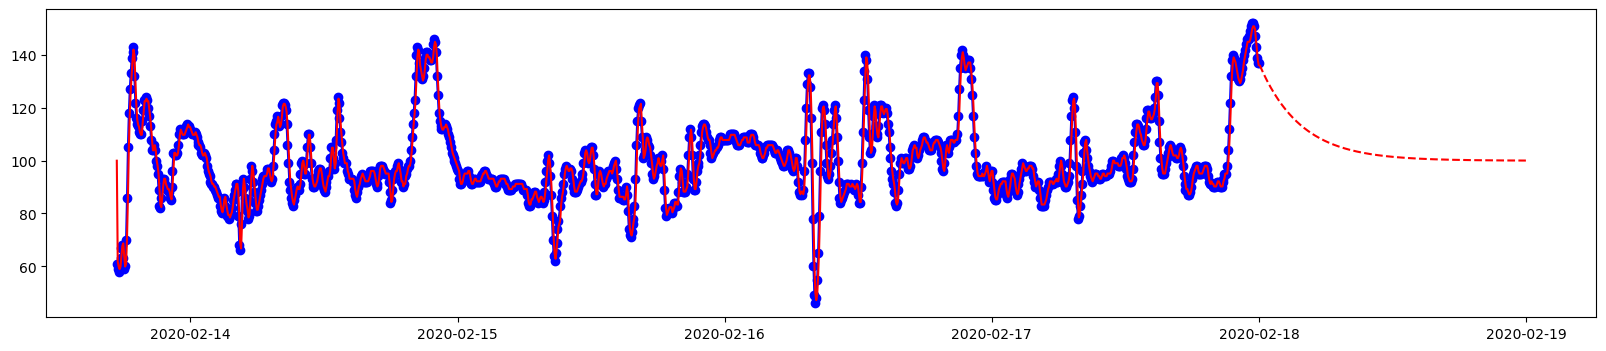

In [38]:
plt.figure(figsize=(20, 4))
plt.plot(glu_train, 'b-o')
plt.plot(glu_train.index, arima.fittedvalues, 'r-')
plt.plot(glu_test.index[:288], arima.forecast(288), 'r--')

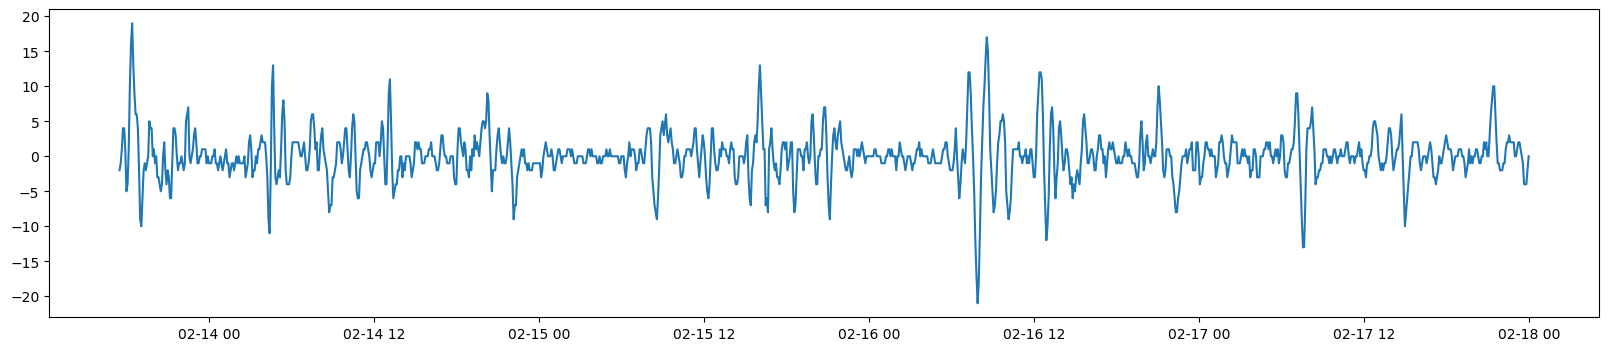

In [39]:
plt.figure(figsize=(20, 4))
plt.plot(glu_train.diff())

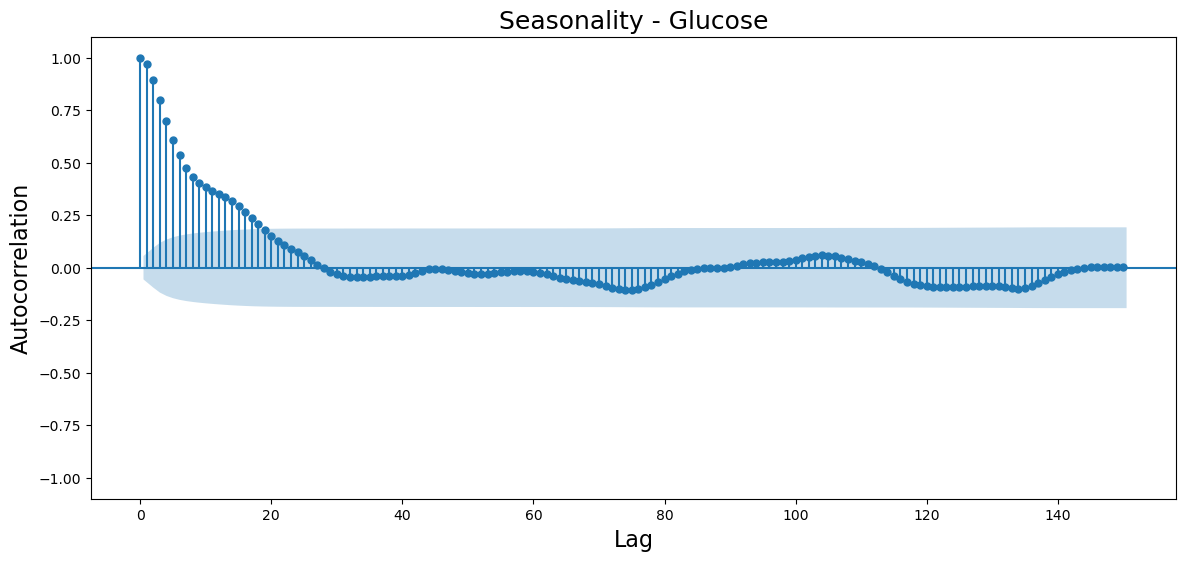

In [40]:
# This is showing seasonality
fig, ax = plt.subplots(1, 1, figsize=(14,6))
sm.api.graphics.plot_acf(glu_train.values, lags=150, ax=ax)
plt.title('Seasonality - Glucose', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

In [41]:
glu_train.diff()[1:]

,glucose
datetime,
2020-02-13 17:28:32,-2.0
2020-02-13 17:33:32,-1.0
2020-02-13 17:38:32,1.0
2020-02-13 17:43:31,4.0
2020-02-13 17:48:31,4.0
...,...
2020-02-17 23:38:28,-4.0
2020-02-17 23:43:27,-4.0
2020-02-17 23:48:28,-4.0


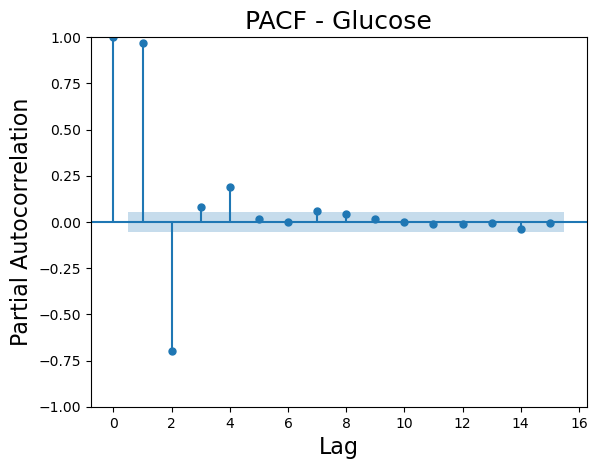

In [42]:
sm.api.graphics.plot_pacf(glu_train.values, lags=15)
plt.title('PACF - Glucose', fontsize=18)
plt.ylabel("Partial Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)
plt.show()


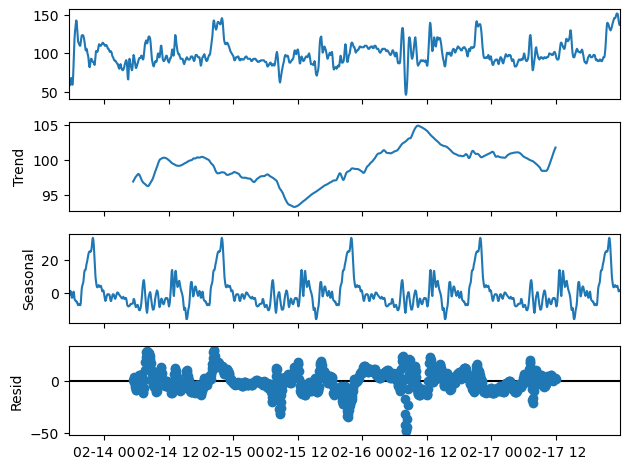

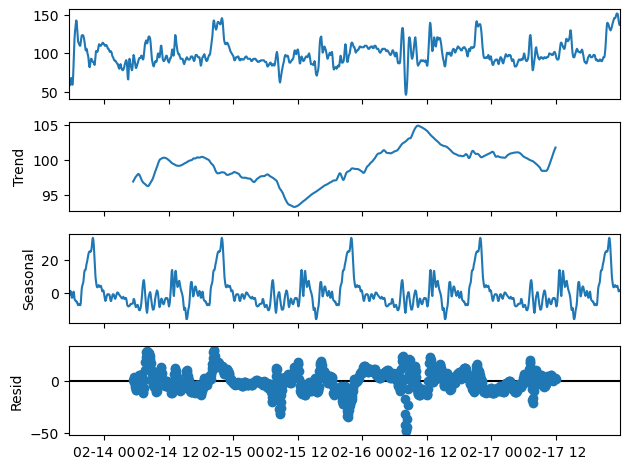

In [43]:
# Seasonal Decomposition
sm.seasonal.seasonal_decompose(glu_train, model='additive', period=288).plot()

## Simplified classification and regression models

In [ ]:
# Max blood glucose 2 hours after a meal